In [1]:
from __future__ import division
from __future__ import print_function

import time
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from utils import load_data, test, train, accuracy, run_experiment
from models import GCN_2, GCN_3, GCN_5
from layers import GraphConvolution

In [2]:
adj, features, labels = load_data(path="../data/cora/", dataset="cora")
print("Total data mean: ", torch.mean(features))
print("Mean of feature variances: ", torch.std(features))

Loading cora dataset...
Total data mean:  tensor(0.0007)
Mean of feature variances:  tensor(0.0071)


In [ ]:
noise_std = 1

In [ ]:
features = features + torch.normal(mean=0, std=noise_std, size=features.shape)
print("Total data mean: ", torch.mean(features))
print("Mean of feature variances: ", torch.std(features))

In [3]:
idx_train = range(140)
idx_val = range(200, 500)
idx_test = range(500, 1500)
idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

In [4]:
hidden = 16
dropout = 0.5
lr = 0.001
weight_decay = 1e-4
num_epochs = 200
smooth_fac = 0.5

In [ ]:
class ite_GCN(nn.Module):
    def __init__(self, nfeat, nclass, dropout, train_nite, eval_nite=0, allow_grad=True, smooth_fac=0):
        '''     
        - This model is a 1-layer GCN with nite iterations, followed by a linear layer and a log_softmax
            - GC layer:     nfeat to nfeat
            - linear layer: nfeat to nclass, (to cast hidden representations of nodes to a dimension of nclass)
        - Activation: ReLu
        - Input:
            - nfeat:        the number of features of each node
            - nclass:       the number of target classes (we are doing a node classification task here)
            - dropout:      dropout rate
            - train_nite:   the number of iterations during training
            - eval_nite:    the number of iterations during evaluation, 
                            if not specified (or invalid), intialize to the same as train_nite
            - allow_grad:   (bool) defaulted to True. 
                            whether or nor allow gradients to flow through all GC iterations, 
                            if False, gradients will only flow to the last iteration
            - smooth_fac:   a number in [0,1], smoothing factor, controls how much of the OLD iteration result is
                            counted in the skip connection in each iteration
                            for example, smooth_fac = x means y_{i+1} = x * y_i + (1-x) * y_{i+1}
                            Invalid inputs will be treated as 0.
        - Output:
            - A probability vector of length nclass, by log_softmax
        '''
        super(ite_GCN, self).__init__()

        self.gc = GraphConvolution(nfeat, nfeat)
        self.linear_no_bias = nn.Linear(nfeat, nclass, bias=False)
        self.dropout = dropout
        self.train_nite = train_nite
        self.allow_grad = allow_grad
        self.smooth_fac = smooth_fac
        self.eval_nite = eval_nite
        
        if (smooth_fac > 1) or (smooth_fac < 0):
            print("Invalid smoothing factor. Treat as 0.")
            self.smooth_fac = 0
        if (eval_nite <= 0):
            print("Unspecified or invalid number of iterations for inference. Treat as the same as training iterations.")
            self.eval_nite = self.train_nite
        
        print("Initialize a 1-layer GCN with ", self.train_nite, "iterations")
        print("Gradient flows to all iterations: ", allow_grad)

    def run_one_layer(self, x, adj):
        x_old = x
        x_new = self.gc(x, adj)
        x = F.relu(self.smooth_fac * x_old + (1 - self.smooth_fac) * x_new)
        x = F.dropout(x, self.dropout, training=self.training)
        return x

    def forward(self, x, adj):
        if self.training:
            for i in range(self.train_nite):
                if not self.allow_grad:
                    # print("no no no! new new")
                    x = x.detach()
                    x = self.run_one_layer(x, adj)
                else:
                    # print("yea yea yea")
                    x = self.run_one_layer(x, adj)
        else:
            for i in range(self.eval_nite):
                x = self.run_one_layer(x, adj)

        
        x = self.linear_no_bias(x)
        return F.log_softmax(x, dim=1)
        

In [ ]:
class EarlyStopper:
    def __init__(self, model_dict, patience=1, activation_iteration=100):
        self.patience = patience
        self.counter = 0
        self.min_acc_val = -np.inf
        self.saved_model = model_dict
        self.activation_iteration = activation_iteration

    def early_stop(self, acc_val, model_dict, iteration):
        if (acc_val >= self.min_acc_val) or (iteration < self.activation_iteration):
            self.min_acc_val = acc_val
            self.saved_model = model_dict
            self.counter = 0
            print("keep")
        else:
            print("ohohoh")
            self.counter += 1
            if self.counter > self.patience:
                return True
        return False
        
    def get_model(self):
        return self.saved_model



In [ ]:
def run_experiment(num_epochs, model, lr, weight_decay, features, adj, idx_train, idx_val, idx_test, labels, patience=3):
    print("runrunrun!")
    optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)
    t_total = time.time()
    loss_TRAIN = []
    acc_TRAIN = []
    loss_VAL = []
    acc_VAL = []
    # early_stopper = EarlyStopper(model.state_dict().copy(), patience=patience)
    for epoch in range(num_epochs):
        t = time.time()
    
        model.train()
        optimizer.zero_grad()
        
        output = model(features, adj)
        
        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        loss_TRAIN.append(loss_train)
        acc_train = accuracy(output[idx_train], labels[idx_train])
        acc_TRAIN.append(acc_train)

        t3 = time.time()
        loss_train.backward()
        t4 = time.time()
        print("backward: ", t4-t3)
        # print("before step: ", model.gc.weight)
        optimizer.step()
        # print("after step: ", model.gc.weight)

        
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        # t1 = time.time()
        output = model(features, adj)
        # print("eval output: ", output)
        # t2 = time.time()
        # print("forward time: ", t2-t1)

        loss_val = F.nll_loss(output[idx_val], labels[idx_val])
        loss_VAL.append(loss_val)
        acc_val = accuracy(output[idx_val], labels[idx_val])
        acc_VAL.append(acc_val)
        print('Epoch: {:04d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train.item()),
            'acc_train: {:.4f}'.format(acc_train.item()),
            'loss_val: {:.4f}'.format(loss_val.item()),
            'acc_val: {:.4f}'.format(acc_val.item()),
            'time: {:.4f}s'.format(time.time() - t))
        # if early_stopper.early_stop(acc_val=acc_val, model_dict=model.state_dict().copy(), iteration=epoch):
        #     model.load_state_dict(early_stopper.get_model())
        #     break
        

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

    # Testing
    test(model, features, adj, idx_test, labels)
    return loss_TRAIN, acc_TRAIN, loss_VAL, acc_VAL

In [ ]:
model3 = ite_GCN(nfeat=features.shape[1],
            nclass=labels.max().item() + 1,
            dropout=dropout,
            train_nite= 3,
            eval_nite= 0,
            allow_grad=True,
            smooth_fac=smooth_fac)
run_experiment(num_epochs=num_epochs, model=model3, lr=lr, weight_decay=weight_decay, features=features, adj=adj, idx_train=idx_train, idx_val=idx_val, idx_test=idx_test, labels=labels)

In [ ]:
hidden = 16
dropout = 0.5
lr = 0.01
weight_decay = 5e-4
num_epochs = 200
smooth_fac = 0.2

In [ ]:
model0 = GCN_5(nfeat=features.shape[1],
            nhid=hidden,
            nclass=labels.max().item() + 1,
            dropout=dropout
)
run_experiment(num_epochs=num_epochs, model=model0, lr=lr, weight_decay=weight_decay, features=features, adj=adj, idx_train=idx_train, idx_val=idx_val, idx_test=idx_test, labels=labels)


# totally messed up

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
l_t = []
for ten in loss_TRAIN:
    l_t.append(ten.item())

In [ ]:
plt.plot(l_t, 'r')

In [ ]:
a_t = []
for ten in acc_TRAIN:
    a_t.append(ten.item())

In [ ]:
plt.plot(a_t, 'r')

In [ ]:
l_v = []
for ten in loss_VAL:
    l_v.append(ten.item())

In [ ]:
plt.plot(l_v, 'r')

In [ ]:
a_v = []
for ten in acc_VAL:
    a_v.append(ten.item())

In [ ]:
plt.plot(a_v, 'r')

In [ ]:
model4 = ite_GCN(nfeat=features.shape[1],
            nclass=labels.max().item() + 1,
            dropout=dropout,
            train_nite = 3,
            allow_grad=False,
            smooth_fac=0.3)

In [ ]:
run_experiment(num_epochs=400, model=model4, lr=lr, weight_decay=weight_decay, features=features, adj=adj, idx_train=idx_train, idx_val=idx_val, idx_test=idx_test, labels=labels)

In [ ]:
for name, param in model3.named_parameters():
    if param.grad is not None:
        print(name, param.grad.abs().sum())

In [ ]:
model1 = GCN_3(nfeat=features.shape[1],
            nhid=hidden,
            nclass=labels.max().item() + 1,
            dropout=dropout)

In [ ]:
model2 = ite_GCN(nfeat=features.shape[1],
            nclass=labels.max().item() + 1,
            dropout=0,
            train_nite= 2,
            eval_nite= 0,
            allow_grad=True,
            smooth_fac=smooth_fac)
run_experiment(num_epochs, model2, lr, weight_decay, features, adj, idx_train, idx_val, idx_test, labels)


In [ ]:
test_losses = []
test_accuracies = []

for i in range(1, 30):
    model = ite_GCN(nfeat=features.shape[1],
            nclass=labels.max().item() + 1,
            dropout=0,
            train_nite= 3,
            eval_nite= i,
            allow_grad=True,
            smooth_fac=smooth_fac)
    model.load_state_dict(model2.state_dict().copy())
    loss_test, acc_test = test(model, features, adj, idx_test, labels)
    test_losses.append(loss_test.item())
    test_accuracies.append(acc_test.item())


In [ ]:
test_losses

In [ ]:
test_accuracies

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_losses)


In [ ]:
plt.plot(test_accuracies)

In [ ]:
a = np.arange(10)


In [ ]:
fig, ax = plt.subplots(2, 2)
fig.tight_layout(pad=5.0)
ax[0, 0].plot(a, 'b') #row=0, col=0
ax[0, 0].title.set_text("Training loss")
ax[0, 1].plot(a, 'b') #row=0, col=1
ax[0, 1].title.set_text("Training accuracy")
ax[1, 0].plot(a, 'b') #row=1, col=0
ax[1, 0].title.set_text("Validation loss")
ax[1, 1].plot(a, 'b') #row=1, col=1
ax[1, 1].title.set_text("Validation accuracy")
plt.show()

In [ ]:
import os
os.path.dirname('__file__')

In [5]:
num_runs = 10

Intialize a 2-layer GCN
runrunrun!
Optimization Finished!
Total time elapsed: 2.0234s
Test set results: loss= 0.5895 accuracy= 0.8380
Testing time:  0.0022869110107421875


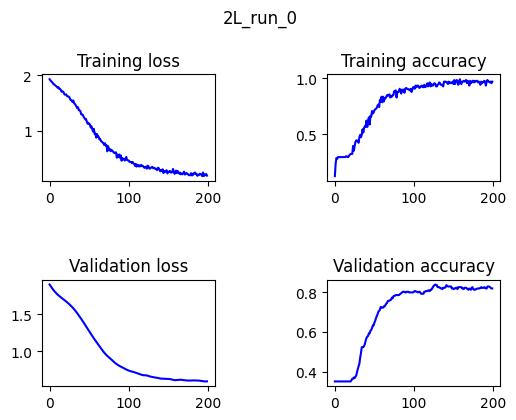

Intialize a 2-layer GCN
runrunrun!
Optimization Finished!
Total time elapsed: 1.9441s
Test set results: loss= 0.6133 accuracy= 0.8410
Testing time:  0.001950979232788086


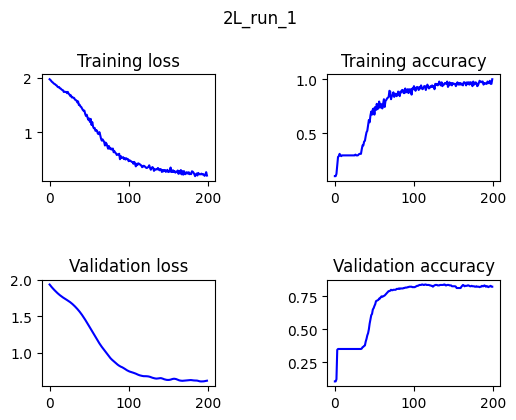

Intialize a 2-layer GCN
runrunrun!
Optimization Finished!
Total time elapsed: 2.3283s
Test set results: loss= 0.5810 accuracy= 0.8300
Testing time:  0.0023119449615478516


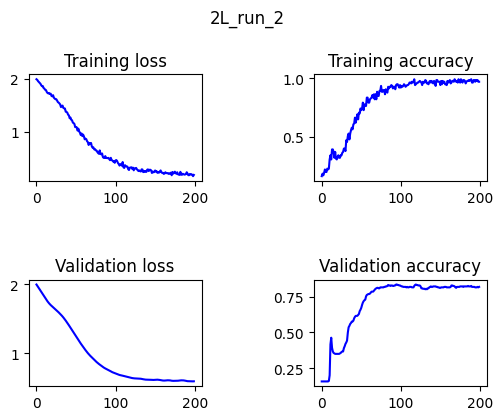

Intialize a 2-layer GCN
runrunrun!
Optimization Finished!
Total time elapsed: 2.2432s
Test set results: loss= 0.5858 accuracy= 0.8420
Testing time:  0.002070188522338867


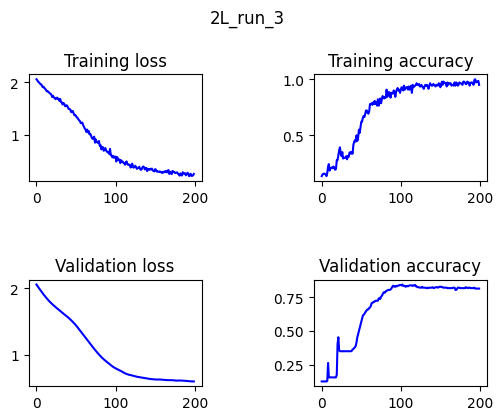

Intialize a 2-layer GCN
runrunrun!
Optimization Finished!
Total time elapsed: 1.8720s
Test set results: loss= 0.5754 accuracy= 0.8320
Testing time:  0.0022971630096435547


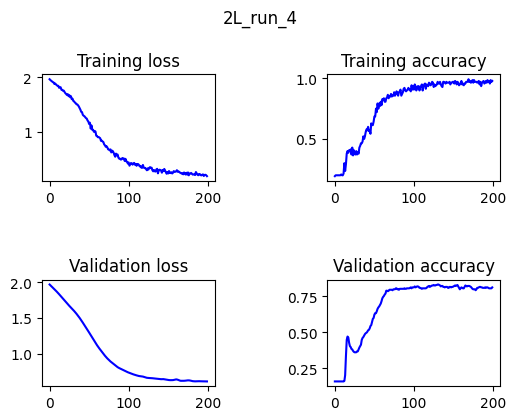

Intialize a 2-layer GCN
runrunrun!
Optimization Finished!
Total time elapsed: 1.7755s
Test set results: loss= 0.6385 accuracy= 0.8300
Testing time:  0.002317667007446289


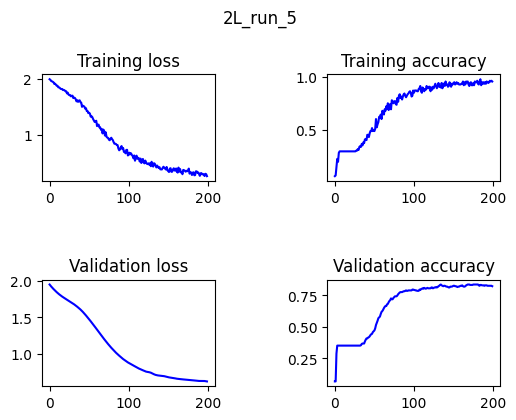

Intialize a 2-layer GCN
runrunrun!
Optimization Finished!
Total time elapsed: 1.8753s
Test set results: loss= 0.6367 accuracy= 0.8310
Testing time:  0.002752065658569336


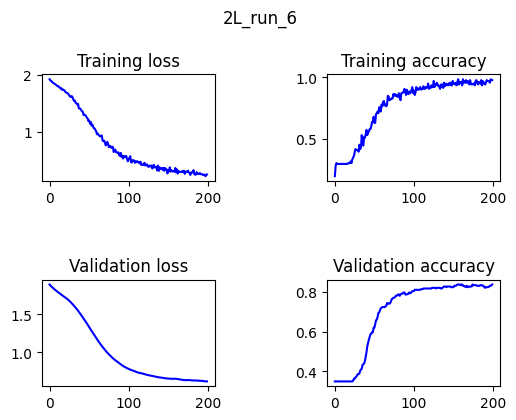

Intialize a 2-layer GCN
runrunrun!
Optimization Finished!
Total time elapsed: 1.8171s
Test set results: loss= 0.6056 accuracy= 0.8300
Testing time:  0.002065896987915039


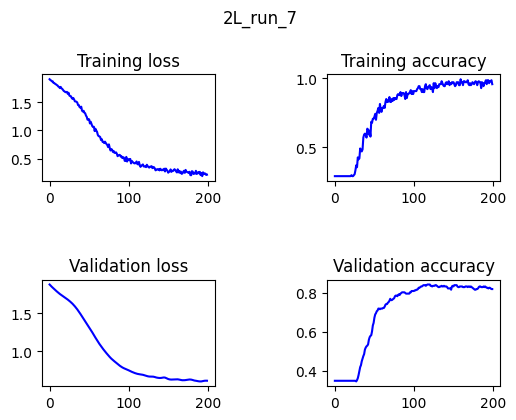

Intialize a 2-layer GCN
runrunrun!
Optimization Finished!
Total time elapsed: 1.7558s
Test set results: loss= 0.5923 accuracy= 0.8250
Testing time:  0.0016829967498779297


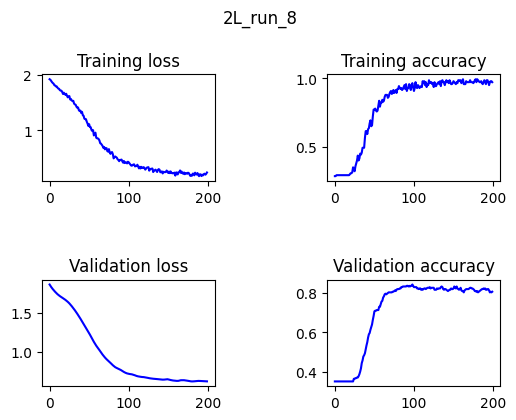

Intialize a 2-layer GCN
runrunrun!
Optimization Finished!
Total time elapsed: 1.7756s
Test set results: loss= 0.5890 accuracy= 0.8380
Testing time:  0.0021238327026367188


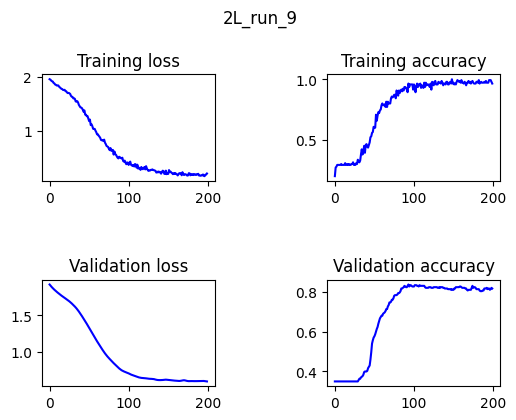

In [6]:
GCN_2_loss = []
GCN_2_acc = []
GCN_2_time = []
for i in range(num_runs):
    # run 2L, 3L ten times each
    model = GCN_2(nfeat=features.shape[1],
            nhid=hidden,
            nclass=labels.max().item() + 1,
            dropout=dropout)
    loss, acc, train_time = run_experiment(num_epochs=num_epochs, model=model, lr=0.01, 
                   weight_decay=weight_decay, features=features, adj=adj, 
                   idx_train=idx_train, idx_val=idx_val, idx_test=idx_test, labels=labels, model_name="2L", run=i)
    GCN_2_loss.append(loss)
    GCN_2_acc.append(acc)
    GCN_2_time.append(train_time)
    del model

In [ ]:
from utils import print_stats
print_stats(model_name="Non-iterative 2 layer", acc_test=GCN_2_acc, training_time=GCN_2_time)
